In [1]:
import h5py
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
import numpy as np

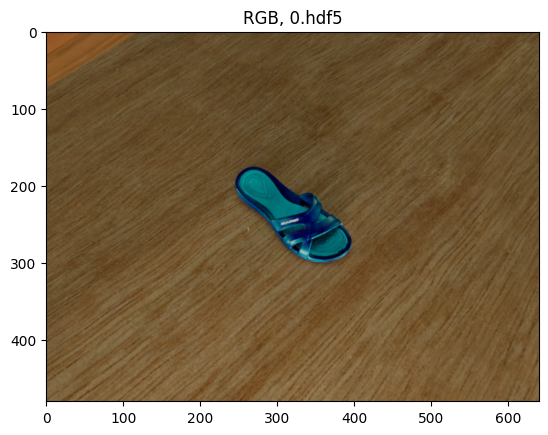

In [2]:
idx = 0
path = Path("../../output/", "dataset_rendered", "shoe-aqua_cyan_right")
mesh_path = Path("../../data", "housecat6d_meshes")
for file_name in os.listdir(path):
    if file_name.endswith('.hdf5'):
        file = h5py.File(path / file_name, 'r')

        rgb = file['colors']
        depth = file['depth']
        instance_attribute_maps = file['instance_attribute_maps']
        instance_segmaps = file['instance_segmaps']

        plt.figure()
        plt.imshow(rgb)
        plt.title(f'RGB, {file_name}')

In [3]:
def load_data(path):
    rgb_images = {}
    masks = {}
    poses = {}
    names = {}
    for object_name in sorted(os.listdir(path)):
        if "flow_images" in object_name:
            continue
        rgb_images_obj = []
        object_masks = []
        scene_names = []
        for file in sorted(os.listdir(os.path.join(path, object_name))):
            if file.endswith(".hdf5"):
                rgb, _, object_mask = load_hdf5(os.path.join(path, object_name, file), object_name)
                rgb_images_obj.append(rgb)
                object_masks.append(object_mask)
                scene_names.append(object_name + "_" + file[:-5])
            if file.endswith(".json"):
                obj_poses = load_poses_json(os.path.join(path, object_name, file))
        rgb_images[object_name] = rgb_images_obj
        masks[object_name] = object_masks
        poses[object_name] = obj_poses
        names[object_name] = scene_names
    return rgb_images, masks, poses, names

def load_hdf5(filepath, object_name):
    with h5py.File(filepath) as f:
        rgb = f['colors']
        depth = f['depth']
        seg = f['instance_segmaps']
        instance_attribute_map = f['instance_attribute_maps']

        # thank blenderproc for saving the data in such a shitty way!
        metadata = data = json.loads(np.array(instance_attribute_map).tobytes().decode('utf-8'))
        object_id = None
        for instance in metadata:
            if instance['name'] == object_name:
                object_id = instance['idx']
                break
        if object_id is None:
            raise ValueError(f"No metadata found for object {object_name}, file: {filepath}")
        
        object_mask = np.array(seg) == object_id

        return np.array(rgb), np.array(depth), object_mask

def visualize_data(rgb_images, object_masks):
    for rgb, object_mask in zip(rgb_images, object_masks):
        plt.subplot(1, 2, 1)
        plt.imshow(rgb)
        plt.subplot(1, 2, 2)
        plt.imshow(object_mask)
        plt.show()

def load_poses_json(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return data

In [4]:
rgb_images, object_masks, poses, scene_names = load_data(path.parent)

In [5]:
import matplotlib.pyplot as plt
obj1 = "shoe-aqua_cyan_right"
obj1_idx = 0
img1 = rgb_images[obj1][obj1_idx]

In [6]:
object1_pose = np.array(poses[obj1][obj1])
cam1_pose = np.array(poses[obj1]['cam_'+str(obj1_idx)])
cam_to_object1 = cam1_pose @ np.linalg.inv(object1_pose)
cam_to_object2 = cam1_pose @ object1_pose
cam_to_object3 = np.linalg.inv(cam1_pose) @ object1_pose
cam_to_object4 = np.linalg.inv(cam1_pose) @ np.linalg.inv(object1_pose)
cam_to_object5 = object1_pose @ np.linalg.inv(cam1_pose)
cam_to_object6 = object1_pose @ cam1_pose
cam_to_object7 = np.linalg.inv(object1_pose) @ cam1_pose
cam_to_object8 = np.linalg.inv(object1_pose) @ np.linalg.inv(cam1_pose)

In [7]:
print(object1_pose)
print(cam1_pose)
print(cam_to_object1)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  7.61992857e-02]
 [ 0.00000000e+00  7.54979013e-08 -1.00000000e+00 -3.51036675e-02]
 [ 0.00000000e+00  1.00000000e+00  7.54979013e-08  9.31285620e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.51887619e-01 -5.66832840e-01  3.36698085e-01  3.22894104e-01]
 [ 6.59291327e-01  6.46443486e-01 -3.83986741e-01 -3.16446291e-01]
 [ 2.22890506e-09  5.10697007e-01  8.59760761e-01  1.56122242e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.51887619e-01 -3.36698128e-01 -5.66832815e-01  7.81664715e-01]
 [ 6.59291327e-01  3.83986790e-01  6.46443457e-01 -9.55227971e-01]
 [ 2.22890506e-09 -8.59760723e-01  5.10697072e-01  1.05543683e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


[[ 0.10525   -0.0174475  0.027434 ]
 [ 0.10569   -0.0160225  0.026945 ]
 [ 0.104849  -0.0157235  0.027775 ]
 ...
 [ 0.114577  -0.0209245  0.008744 ]
 [ 0.11488   -0.0205305  0.009228 ]
 [ 0.114577  -0.0209245  0.008744 ]]
0.123990997672081
[[0.06104914 0.08630408 0.70171737]
 [0.06170236 0.08550964 0.70053183]
 [0.06052281 0.08541678 0.70023922]
 ...
 [0.08038415 0.0812846  0.70874309]
 [0.08029287 0.08156801 0.70811647]
 [0.08038415 0.0812846  0.70874309]]
0.7993842996946161
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563e84859cf0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


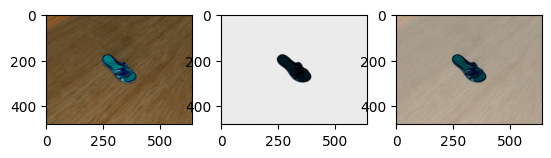

In [31]:
import open3d as o3d

model = o3d.io.read_triangle_model(str(mesh_path / 'shoe' / f"{obj1}.obj"))
mesh = model.meshes[0].mesh
mesh_name = model.meshes[0].mesh_name
mat = model.materials[0]

transform = cam_to_object3

print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))
rot_x_180 = np.eye(4)
rot_x_180[1, 1] = -1
rot_x_180[2, 2] = -1
mesh.transform((rot_x_180 @ transform))
print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))

width = 640  
height = 480  
intrinsics = np.array([[538.391033533567, 0.0, 315.3074696331638], 
                       [0.0, 538.085452058436, 233.0483557773859], 
                       [0.0, 0.0, 1.0]], dtype=np.float64)
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]

intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

if 'renderer' in globals():
    del renderer
renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
renderer.scene.add_geometry(mesh_name, mesh, mat)
renderer.setup_camera(intrinsics, np.eye(4, dtype=np.float64))
img = renderer.render_to_image()
img_np = np.asarray(img)
img_labeled = img1.copy()
alpha = 0.5
img_labeled = (img_labeled * alpha + img_np * (1 - alpha)).astype(np.uint8)
# print both
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img_np)
plt.subplot(1, 3, 3)
plt.imshow(img_labeled)
plt.show()

In [22]:
(img_np == 0).sum()

4486